## Quantum Layers Application

In [2]:
#Import the required modules
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split


## Convolutional Layers

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(a[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(a[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(a[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     ├──────────┤└────┬────┘└────┬────┘                      
q_3: ┤ Rx(a[3]) ├─────■──────────■───────────────────────────
     └──────────┘                                            


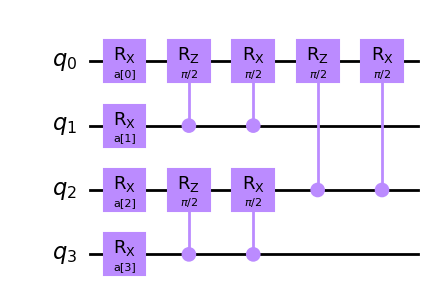

In [3]:
def conv_circuit(params):
    target = QuantumCircuit(4)
    #Apply the Rx gate with given parameteres
    for i in range(len(params)):
        target.rx(params[i],i)
    #Assuming that the gates without the angle are rotated by pi/2
    target.crz(np.pi / 2, 1, 0)
    target.crx(np.pi / 2, 1, 0)
    target.crz(np.pi/2, 3, 2) #Apply controlled Rz to 3rd and 4
    target.crx(np.pi/2 , 3, 2)
    target.crz(np.pi/2 , 2, 0)
    target.crx(np.pi/2, 2, 0 )
    print(target)
    return target

params = ParameterVector("a",length = 4)
circuit = conv_circuit(params)
circuit.draw("mpl")

    
    

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(θ[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(θ[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(θ[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └──────────┘└────┬────┘└────┬────┘                      
q_3: ─────────────────■──────────■───────────────────────────
                                                             
     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(θ[3]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(θ[4]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(θ[5]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └──────────┘└────┬────┘└────┬────┘                      
q_3: ───

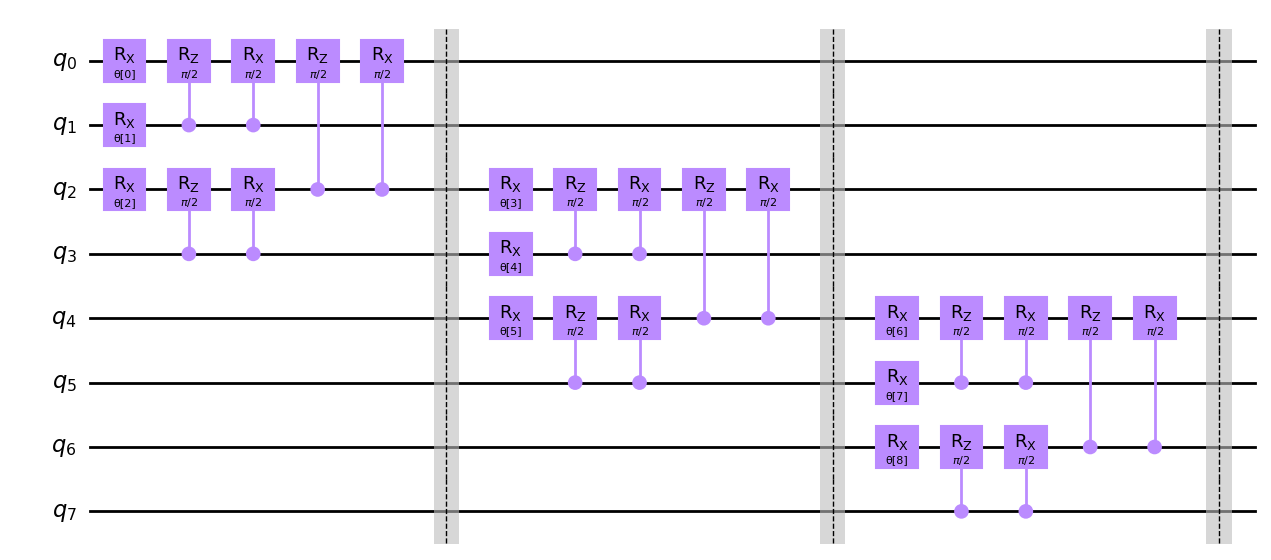

In [4]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)

    for i in range(0, num_qubits - 3, 2):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), qubits[i : i + 4])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl")

## Pooling Layers

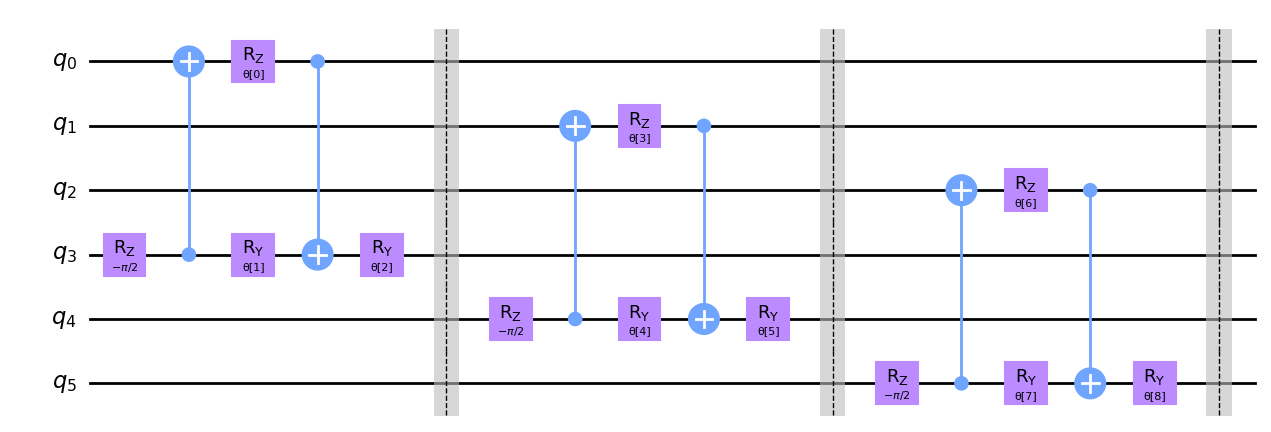

In [5]:

#Defining a single pooling layer
def pooling_circuit(params) :
    target = QuantumCircuit(2)          #We are defining a quantum circuit with 2 qubits
    target.rz(-np.pi / 2,1)             #Applying the Rz gate to the qubit at position 1
    target.cx(1,0)                      #Apply CNOT gate with second qubit as control and first qubit as control
    target.rz(params[0], 0)             #Apply a rotation angle stored in params[0] to qubit in position 0
    target.ry(params[1],1)
    target.cx(0,1)
    target.ry(params[2],1)

    return target

#Define the layer  for a larger number of qubits
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks) #The number of qubits is equal to the total number of sources and sinks. Sources are original qubits and sinks are qubits after pooling
    qc = QuantumCircuit(num_qubits, name = "Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length = num_qubits // 2*3) #We divide num_qubits by 2 as we need a parameter vector for each pair of source and sinks. 
    # The number of paramters is 3 as we use the 3 of them in the pooling_circuit code. The params array contain a rotation angle for X, Y and Z axis. Hence size is 3

    for source, sink in zip(sources, sinks):
        qc = qc.compose(pooling_circuit(params[param_index : (param_index + 3)]), [source, sink]) #The first three parameters are sent to compose the circuit on the source and sink
        qc.barrier()
        param_index+=3 #Switch to the next set of 3 parameters after first layer
    
    qc_inst = qc.to_instruction() #Convert the quantum circuit into a single instruction to add to other circuits
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc # Return the quantum circuit


sources = [0,1, 2]
sinks = [3, 4,5]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

## Generating the dataset in the same way

In [6]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6,8))
    ver_array = np.zeros((4,8))
    j = 0
    for i in range(0,7):
        if i !=3:
            hor_array[j][i] = np.pi/2
            hor_array[j][i+1] = np.pi/2
            j+=1
    j =0
    for i in range(0,4):
        ver_array[j][i] = np.pi/2
        ver_array[j][i+4] = np.pi/2
        j+=1
    
    for n in range(num_images):
        rng = algorithm_globals.random.integers(0,2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0,6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0,4)
            images.append(np.array(ver_array[random_image]))
        
        #noise generation
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi/4)
        
    return images,labels


In [7]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

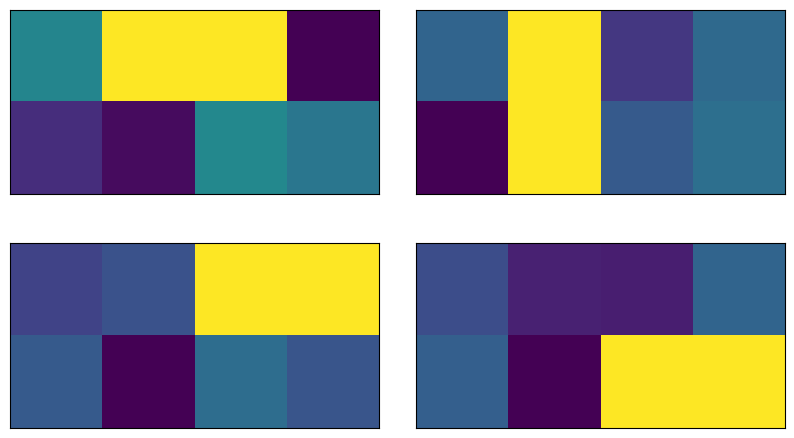

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2,4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

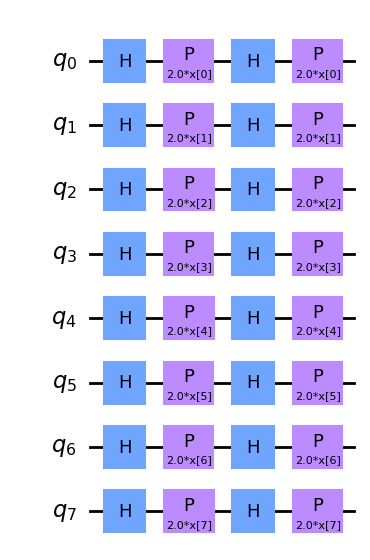

In [9]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

## Training

In [10]:

feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

     ┌───────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(с1[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├───────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(с1[1]) ├─────■──────────■──────────┼──────────┼─────
     ├───────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(с1[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └───────────┘└────┬────┘└────┬────┘                      
q_3: ──────────────────■──────────■───────────────────────────
                                                              
     ┌───────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(с1[3]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├───────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(с1[4]) ├─────■──────────■──────────┼──────────┼─────
     ├───────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(с1[5]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └───────────┘└────┬────┘└────┬────┘               

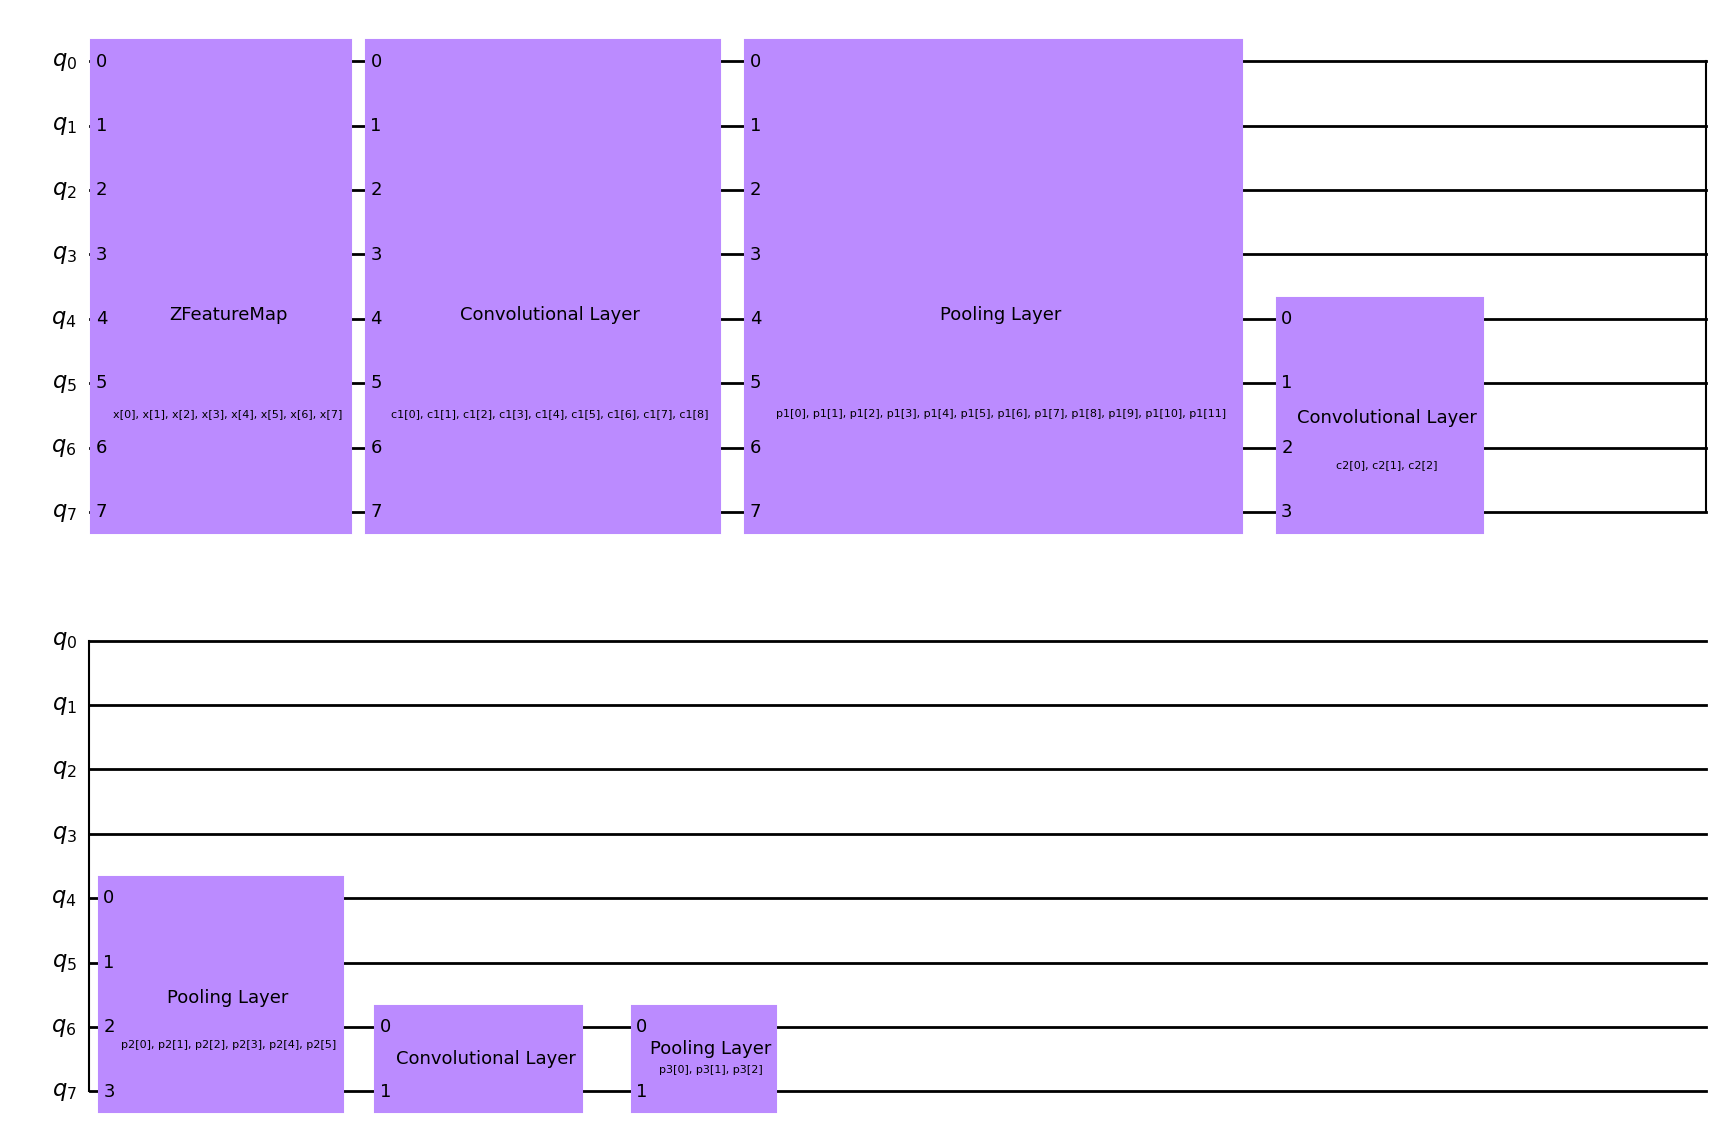

In [11]:
circuit.draw("mpl")

In [12]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [13]:
initial_point = np.random.rand(33) #24 = 8*3

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

## Possible VQE Implementation instead of COBYLA

In [69]:
from qiskit import QuantumCircuit

# Trying the VQE for a simple circuit

# Create a quantum circuit
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.rx(0.5, 0)
circuit.ry(1.2, 1)
circuit.ry(1.5,1)

# Get the parameter values
parameter = []
for gate in circuit.data:
    # append gate parameters
    parameter.append(gate[0].params)
    circuit.data[1][0].params = [3.3]  # replace the parameters of the first gate
    circuit.data[3][0].params = [3.4]


print(circuit)


# Check the parameters of the gates
for i in range(len(parameter)):
    print(f"Parameter values for gate {i+1}:", parameter[i])


        ┌───┐   ┌─────────┐
q_0: ───┤ H ├───┤ Rx(3.3) ├
     ┌──┴───┴──┐├─────────┤
q_1: ┤ Ry(1.2) ├┤ Ry(3.4) ├
     └─────────┘└─────────┘
Parameter values for gate 1: []
Parameter values for gate 2: [3.3]
Parameter values for gate 3: [1.2]
Parameter values for gate 4: [3.4]


We print the paramter to see how they are stored

In [27]:
print(parameter)

[[], [0.5], [1.2], [1.5]]


Convert this parameter into a Hamiltonian matrix

In [32]:
!pip3 install qiskit.providers.aer

ERROR: Could not find a version that satisfies the requirement qiskit.providers.aer (from versions: none)
ERROR: No matching distribution found for qiskit.providers.aer


Another Way

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitStateFn, Z, I
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import QasmSimulator
state = CircuitStateFn(circuit)

H = Z^Z
vqe = VQE(ansatz=circuit, operator=H, quantum_instance=QuantumInstance(QasmSimulator()))

# Run VQE with initial parameters
result = vqe.compute_minimum_eigenvalue(parameter)  # compute Eigen Value of parameters
print(result)




In [83]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.algorithms import VQE
from qiskit.opflow import Z,X, I, StateFn, PauliExpectation, AerPauliExpectation
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow.gradients import Gradient, NaturalGradient
from qiskit.opflow import CircuitStateFn
from qiskit.opflow import PauliSumOp

# Create a quantum circuit
theta = Parameter('θ')
phi = Parameter('φ')
gamma = Parameter('γ')

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.rx(theta, 0)
circuit.ry(phi, 1)
circuit.ry(gamma,1)

# Hamiltonian
H = Z ^ Z + X

# Define your problem
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit import Aer
expectation = StateFn(H, is_measurement=True).compose(StateFn(circuit)) #Defining the expectation value of the hamiltonian with respect to the state prepared by the circuit
sampler = CircuitSampler(Aer.get_backend('qasm_simulator'))
problem = sampler.convert(expectation)

# Run VQE
optimizer = COBYLA()
#vqe = VQE(ansatz=circuit, optimizer=optimizer, quantum_instance=QuantumInstance(AerSimulator()))


#Non random samples for consistent values 
from qiskit.utils import algorithm_globals

# set the random seed for Qiskit
algorithm_globals.random_seed = 12345

# use the same seed for the quantum instance
qi = QuantumInstance(AerSimulator(), seed_simulator=12345, seed_transpiler=12345)

vqe = VQE(ansatz=circuit, optimizer=optimizer, quantum_instance=qi)

result = vqe.compute_minimum_eigenvalue(H)

optimal_params_dict = result.optimal_parameters
#Convert to array values 
optimal_param_array = np.array(list(optimal_params_dict.values()))

#Now insert it back into the circuit
for i in range(len(optimal_param_array)):
               circuit.data[i+1][0].params = [optimal_param_array[i]]




print(circuit)
print(result)
print(optimal_params_dict)
print(optimal_param_array)


          ┌───┐     ┌─────────────┐
q_0: ─────┤ H ├─────┤ Rx(-1.8888) ├
     ┌────┴───┴────┐└┬────────────┤
q_1: ┤ Ry(-2.0965) ├─┤ Ry(5.0927) ├
     └─────────────┘ └────────────┘
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': {'01': 0.03125, '10': 0.71875, '11': 0.6945659615904022},
    'eigenvalue': (-1.033203125+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   Parameter(θ): -2.096514231391254,
                              Parameter(γ): -1.8888145978318447,
                              Parameter(φ): 5.092721801738452},
    'optimal_point': array([-1.8888146 , -2.09651423,  5.0927218 ]),
    'optimal_value': -1.033203125,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.07296395301818848}
{Parameter(γ): -1.8888145978318447, Parameter(θ): -2.096514231391254, Parameter(φ): 5.092721801738452}
[-1.8888146  -2.09651423  5.0927218 ]


/var/folders/wz/qr8rb0xd5sgb2h2_nqm2llnm0000gn/T/ipykernel_15235/2000315267.py:29: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(H, is_measurement=True).compose(StateFn(circuit)) #Defining the expectation value of the hamiltonian with respect to the state prepared by the circuit
/var/folders/wz/qr8rb0xd5sgb2h2_nqm2llnm0000gn/T/ipykernel_15235/2000315267.py:29: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(H, is_measurement=True).compose(StateFn(circuit)) #Defining the expectation value of the hami

In [14]:
print(f"The QNN requires {qnn.num_weights} parameters.")


The QNN requires 33 parameters.


In [ ]:
/Users/pravinmahendran/Documents/GitHub/qcnn/Subteam 2/QPL - Qis - JUP.ipynb

## Trying the Quantum Natural Gradient Descent

## Testing the Model 

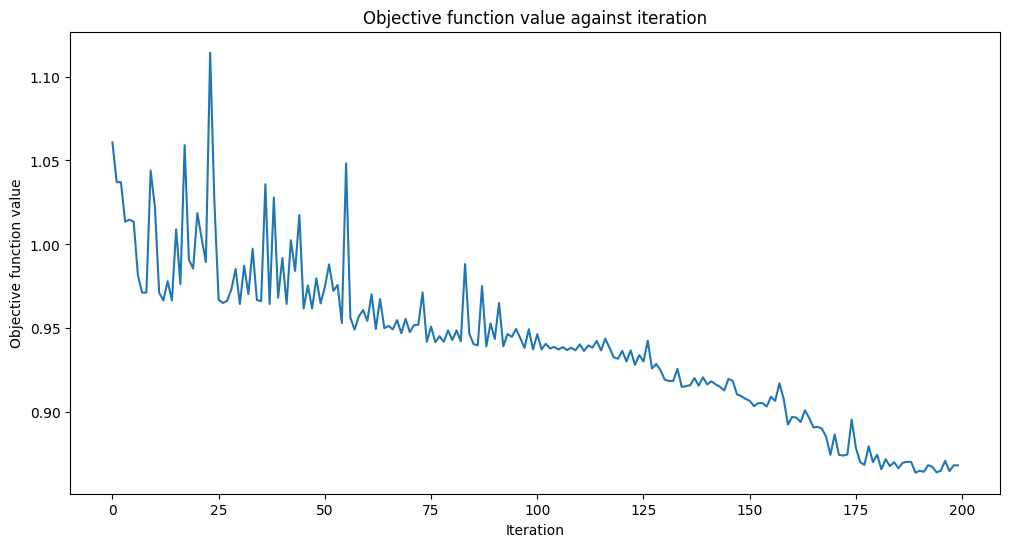

Accuracy from the train data : 77.14%


In [15]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 60.0%


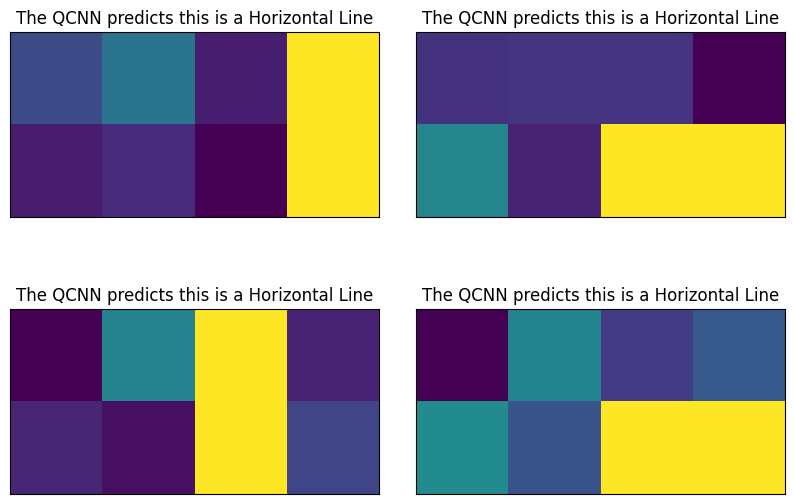

In [16]:

y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)